In [2]:
import numpy as np
import scipy as scipy
from scipy import special
import matplotlib.pyplot as plt
from matplotlib import animation
import matplotlib as mpl
global_dpi = 150
mpl.rcParams['figure.dpi']= global_dpi
import copy
import io
import base64
import math
from IPython.display import HTML
from IPython.display import clear_output
import random
import numba
import time
import cv2 as cv
import seaborn as sns

In [3]:
####source: https://stackoverflow.com/questions/3279560/reverse-colormap-in-matplotlib
def reverse_colourmap(cmap, name = 'my_cmap_r'):
    """
    In: 
    cmap, name 
    Out:
    my_cmap_r

    Explanation:
    t[0] goes from 0 to 1
    row i:   x  y0  y1 -> t[0] t[1] t[2]
                   /
                  /
    row i+1: x  y0  y1 -> t[n] t[1] t[2]

    so the inverse should do the same:
    row i+1: x  y1  y0 -> 1-t[0] t[2] t[1]
                   /
                  /
    row i:   x  y1  y0 -> 1-t[n] t[2] t[1]
    """        
    reverse = []
    k = []   

    for key in cmap._segmentdata:    
        k.append(key)
        channel = cmap._segmentdata[key]
        data = []

        for t in channel:                    
            data.append((1-t[0],t[2],t[1]))            
        reverse.append(sorted(data))    

    LinearL = dict(zip(k,reverse))
    my_cmap_r = mpl.colors.LinearSegmentedColormap(name, LinearL) 
    return my_cmap_r
#########


## Gray-Scott model

In [4]:
@numba.njit(parallel=True, fastmath=False)
def GrayScott(dx,dt,f,k,max_time, u_matrix, v_matrix, D_u, D_v, sink): 
    u_results = [u_matrix.copy()]
    v_results = [v_matrix.copy()]
    u_mat = u_matrix.copy()
    v_mat = v_matrix.copy()
    for y in range(0,u_mat.shape[0]):
            for x in range(0,u_mat.shape[1]):
                if sink[y,x] == 1:
                    u_mat[y,x] = 0
                    v_mat[y,x] = 0
    for i in range(int(max_time/dt)):
        u_cache = u_mat.copy()
        v_cache = v_mat.copy()
        for y in range(0,u_mat.shape[0]):
            for x in range(0,u_mat.shape[1]):
                if sink[y,x] == 0:
                    x_up = x + 1
                    x_down = x - 1
                    y_up = y + 1
                    y_down = y - 1
                    if x_up == u_mat.shape[1]:
                        x_up = 0 
                    if y_up == u_mat.shape[0]:
                        y_up = 0     
                    u_mat[y,x] = u_cache[y,x] + dt*(D_u*( u_cache[y, x_up] + u_cache[y, x_down] + u_cache[y_up,x]
                                                         + u_cache[y_down,x] - 
                                                          4 * u_cache[y,x])/(dx**2) - u_cache[y,x]*v_cache[y,x]**2 + f*(1- u_cache[y,x]))
                    v_mat[y,x] = v_cache[y,x] + dt*(D_v*( v_cache[y, x_up] + v_cache[y, x_down] + v_cache[y_up,x]
                                                         + v_cache[y_down,x] - 
                                                          4 * v_cache[y,x])/(dx**2) + u_cache[y,x]*v_cache[y,x]**2 - (f+k)*v_cache[y,x])
        #u_results.append(u_mat.copy())
        #v_results.append(v_mat.copy())
    return u_mat, v_mat

In [41]:
dimensions = 200
square_size = 20
assert dimensions//2 - dimensions/2 == 0 
assert dimensions > square_size
dx = 1
dt = 1
max_time = 20000

D_u = 0.16
D_v = 0.08
f = 0.0413
k = 0.0628
sink = np.zeros((dimensions,dimensions))
ones = np.ones(dimensions)
#sink[0,:] = ones
#sink[-1,:] = ones
#sink[:,0] = ones
#sink[:,-1] = ones
initial_u = 0.5
initial_v = 0.25
u_matrix = 1*np.ones((dimensions,dimensions))
v_matrix = np.zeros((dimensions,dimensions))
v_block = initial_v*np.ones((square_size,square_size))
v_matrix[int(dimensions/2-square_size/2):int(dimensions/2 + square_size/2),int(dimensions/2-square_size/2):int(dimensions/2 + square_size/2)] = v_block
u_block = initial_u*np.ones((square_size,square_size))
u_matrix[int(dimensions/2-square_size/2):int(dimensions/2 + square_size/2),int(dimensions/2-square_size/2):int(dimensions/2 + square_size/2)] = u_block
def add_noise(matrix,noise = 0.05):
    for y in range(matrix.shape[0]):
        for x in range(matrix.shape[1]):
            matrix[y,x] = max(0,matrix[y,x] + np.random.normal(0,noise/3))
    return matrix

v_matrix = add_noise(v_matrix)
u_matrix = add_noise(u_matrix)
u_results, v_results = GrayScott(dx,dt,f,k,max_time, u_matrix, v_matrix, D_u, D_v,sink)


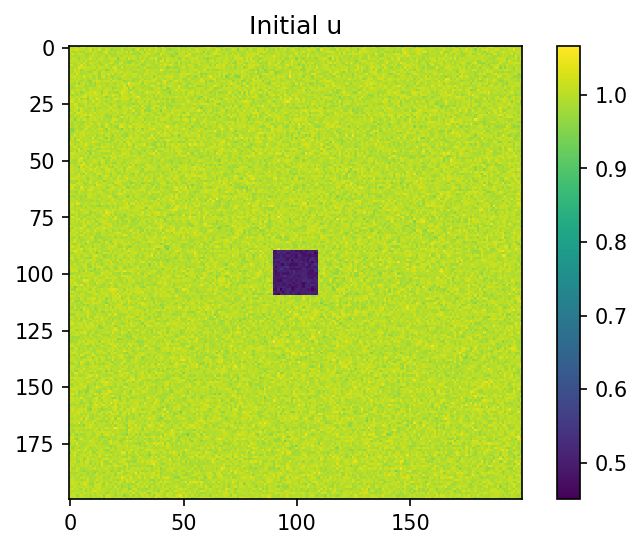

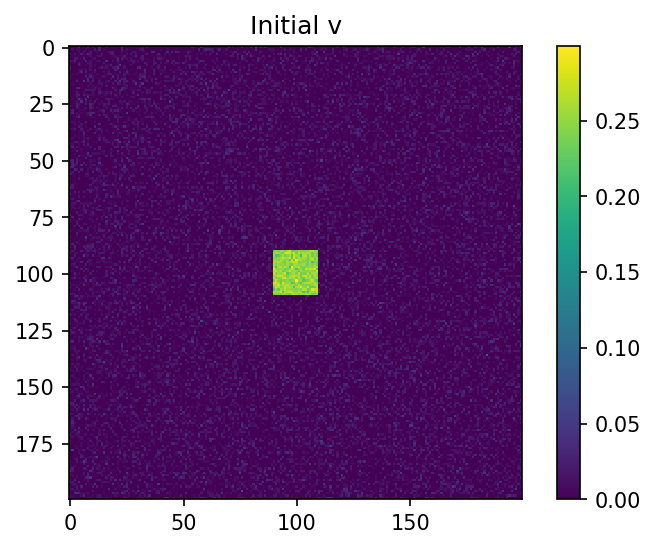

In [42]:
plt.imshow(u_matrix)
plt.colorbar()
plt.title('Initial u')
plt.show()
plt.imshow(v_matrix)
plt.colorbar()
plt.title('Initial v')
plt.show()

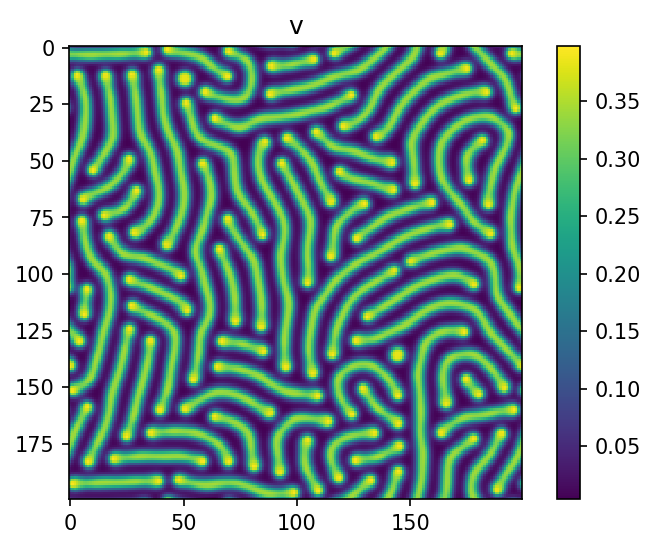

In [43]:
plt.imshow(v_results)
plt.colorbar()
plt.title('v')
plt.show()

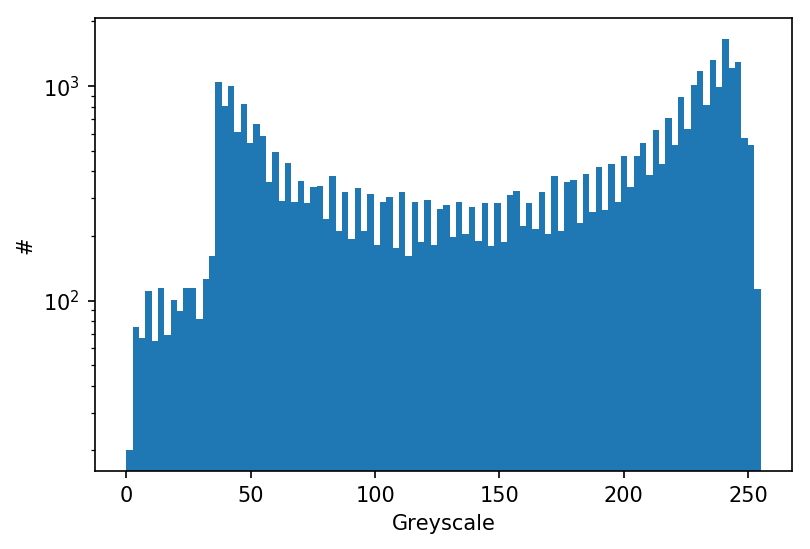

In [44]:
def normalizer(matrix):
    shape = matrix.shape
    new_matrix = np.zeros(shape, dtype = np.uint8)
    maxi = np.max(matrix)
    mini = np.min(matrix)
    for y in range(matrix.shape[0]):
        for x in range(matrix.shape[1]):
            new_matrix[y,x] = 255 - np.round(255*(matrix[y,x]-mini)/(maxi-mini))
    return new_matrix

img = normalizer(v_results)
plt.hist(img.ravel(),100)
plt.yscale('log')
plt.ylabel('#')
plt.xlabel('Greyscale')
plt.show()

## Binarized image

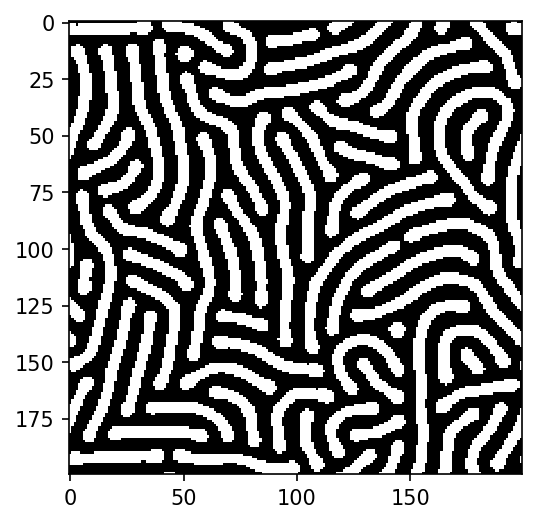

In [45]:
ret2,th2 = cv.threshold(img,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
plt.imshow(th2,cmap = 'Greys')
#print(th2)

In [46]:
#detector = cv.SimpleBlobDetector_create()
#params = cv.SimpleBlobDetector_Params()
 
# Change thresholds

# Filter by Circularity
#params.filterByCircularity = False
#params.filterByInertia = False
#params.filterByConvexity = False
#params.filterByArea = False
# Detect blobs.
#keypoints = detector.detect(th2)
 
# Draw detected blobs as red circles.
# cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS ensures the size of the circle corresponds to the size of blob
#im_with_keypoints = cv.drawKeypoints(th2, keypoints, np.array([]), (0,0,255), cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
 
# Show keypoints
#cv.imshow("Keypoints", im_with_keypoints)
#cv.waitKey(0)

## Blob detector

In [47]:
def supplement(matrix,check,y,x, Neumann = True):
    pos_list = []
    y1 = y - 1 - matrix.shape[0]*((y-1)//(matrix.shape[0]+1))
    y2 = y + 1 - matrix.shape[0]*((y+1)//matrix.shape[0])
    x1 = x-1 - matrix.shape[1]*((x-1)//(matrix.shape[1]+1))
    x2 = x + 1 - matrix.shape[1]*((x+1)//matrix.shape[1])
    if check[y1,x] == 0:
        check[y1,x] = 1
        if matrix[y1,x] == 0:
            pos_list.append((y1,x))
    if check[y, x1] == 0:
        check[y,x1] = 1
        if matrix[y,x1] == 0:
            pos_list.append((y,x1))
    if check[y2,x] ==0:
        check[y2,x] = 1
        if matrix[y2,x] == 0:
            pos_list.append((y2,x))
    if check[y,x2] ==0:
        check[y,x2] = 1
        if matrix[y,x2] == 0:
            pos_list.append((y,x2))
    if not Neumann:
        if check[y1,x1] == 0:
            check[y1,x1] = 1
            if matrix[y1,x1] == 0:
                pos_list.append((y1,x1))
        if check[y2, x1] == 0:
            check[y2,x1] = 1
            if matrix[y2,x1] == 0:
                pos_list.append((y2,x1))
        if check[y2,x2] ==0:
            check[y2,x2] = 1
            if matrix[y2,x2] == 0:
                pos_list.append((y2,x2))
        if check[y1,x2] ==0:
            check[y1,x2] = 1
            if matrix[y1,x2] == 0:
                pos_list.append((y1,x2))
    return pos_list

def blob_detector(matrix,supplement,print_time = False, Neumann = True):
    start_time = time.time()
    check = np.zeros(matrix.shape)
    blob_sizes = []
    for y in range(matrix.shape[0]):
        for x in range(matrix.shape[1]):
            if check[y,x] == 0:
                if matrix[y,x] == 0:
                    check[y,x] = 1
                    counter = 1
                    pos_list = supplement(matrix,check,y,x,Neumann = Neumann)
                    counter += len(pos_list)
                    new_pos_list = [0]
                    while len(new_pos_list) > 0:
                        new_pos_list = []
                        for i in pos_list:
                            cache = supplement(matrix,check,i[0],i[1], Neumann = Neumann)
                            new_pos_list.extend(cache)
                        counter += len(new_pos_list)
                        pos_list = copy.deepcopy(new_pos_list)
                    blob_sizes.append(counter)
    total_time = time.time()-start_time
    if print_time:
        print('Execution time: ' + str(total_time))
    return blob_sizes

test = 255*np.ones((10,10))
test[0:3,2:6],test[7:10,3:5],test[4:6,7:9] = 0,0,0
print(test)
print(blob_detector(test,supplement))

[[255. 255.   0.   0.   0.   0. 255. 255. 255. 255.]
 [255. 255.   0.   0.   0.   0. 255. 255. 255. 255.]
 [255. 255.   0.   0.   0.   0. 255. 255. 255. 255.]
 [255. 255. 255. 255. 255. 255. 255. 255. 255. 255.]
 [255. 255. 255. 255. 255. 255. 255.   0.   0. 255.]
 [255. 255. 255. 255. 255. 255. 255.   0.   0. 255.]
 [255. 255. 255. 255. 255. 255. 255. 255. 255. 255.]
 [255. 255. 255.   0.   0. 255. 255. 255. 255. 255.]
 [255. 255. 255.   0.   0. 255. 255. 255. 255. 255.]
 [255. 255. 255.   0.   0. 255. 255. 255. 255. 255.]]
[18, 4]


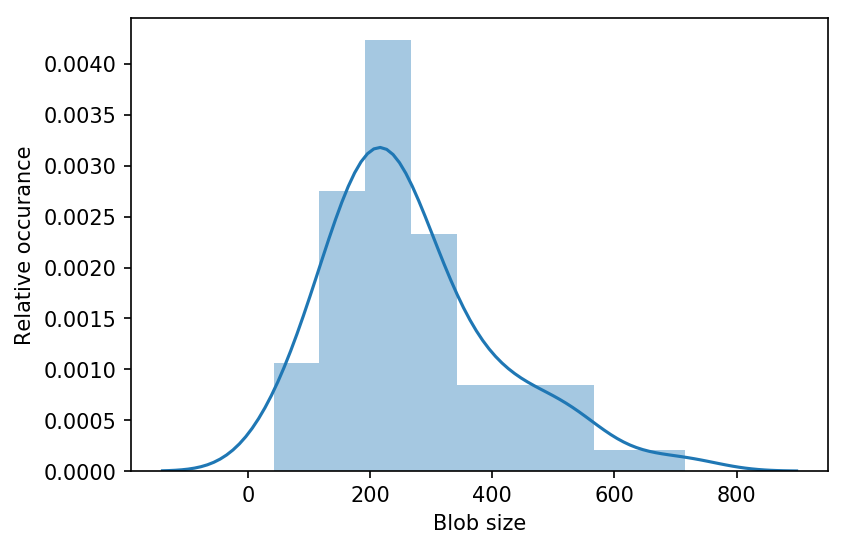

In [48]:
sns.distplot(blob_detector(th2,supplement))
plt.xlabel('Blob size')
plt.ylabel('Relative occurance')
plt.show()

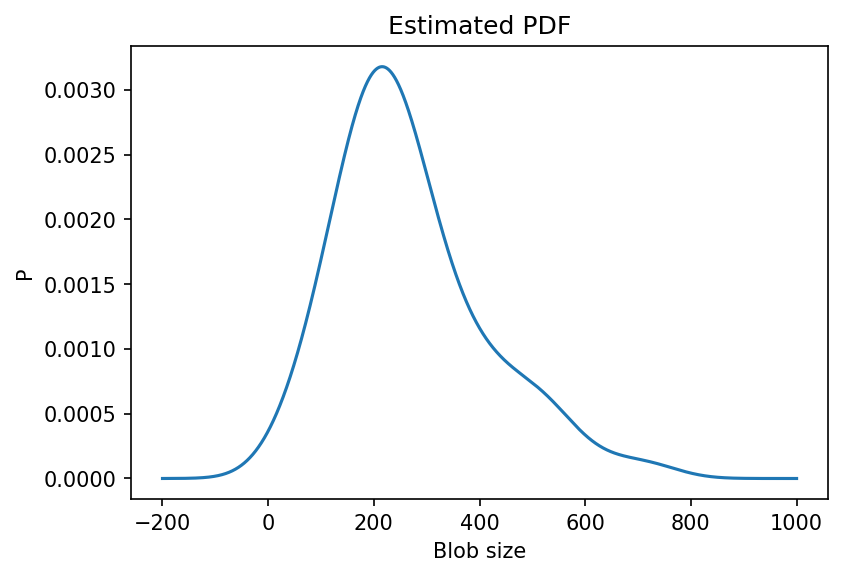

In [49]:
kernel = scipy.stats.gaussian_kde(blob_detector(th2,supplement))
x = np.linspace(-200,1000,10000)
plt.plot(x,kernel(x))
plt.xlabel('Blob size')
plt.ylabel('P')
plt.title('Estimated PDF')
plt.show()

## Shannon entropy

In [50]:
def funct(x,kernel):
        return kernel(x)*np.log(1/kernel(x))

def shannon_entropy(kernel,funct,a,b, acc = 10000):
    xs = np.linspace(a,b,acc)
    evaluate = funct(xs,kernel)
    for i in range(len(xs)):
        if math.isnan(evaluate[i]):
            xs[i] = float('nan')
    diff = np.abs(np.nanmax(xs) - np.nanmin(xs))
    a = np.nanmin(xs) + 0.1*diff
    b = np.nanmax(xs) - 0.1*diff
    entropy = scipy.integrate.quad(funct,a,b,args = kernel)
    return entropy[0]

print(shannon_entropy(kernel,funct,-10000,10000))

6.386056954253652


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in true_divide
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  


## Final function

In [70]:
def final_function(u_matrix,v_matrix,F_list,k_list,dx,dt,max_time,D_u,D_v,sink,GrayScott,normalizer,supplement
                   ,blob_detector,funct,shannon_entropy):
    results = []
    for f in f_list:
        cache = []
        for k in k_list:
            u_results, v_results = GrayScott(dx,dt,f,k,max_time, u_matrix, v_matrix, D_u, D_v,sink)
            #print(v_results)
            img = normalizer(v_results)
            ret2,th2 = cv.threshold(img,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
            if (k == k_list[-1] and f == f_list[-1]):
                print('Top-right corner:')
                print('k = ' + str(k))
                print('F = ' + str(f))
                plt.imshow(th2,cmap = 'Greys')
                plt.show()
                print('\n')
            if (k == k_list[0] and f == f_list[0]):
                print('Bottom-left corner:')
                print('k = ' + str(k))
                print('F = ' + str(f))
                plt.imshow(th2,cmap = 'Greys')
                plt.show()
                print('\n')
            if (k == k_list[0] and f == f_list[-1]):
                print('Top-left corner:')
                print('k = ' + str(k))
                print('F = ' + str(f))
                plt.imshow(th2,cmap = 'Greys')
                plt.show()
                print('\n')
            if (k == k_list[-1] and f == f_list[0]):
                print('Bottom-right corner:')
                print('k = ' + str(k))
                print('F = ' + str(f))
                plt.imshow(th2,cmap = 'Greys')
                plt.show()
                print('\n')
            if (k == k_list[int(np.round(len(k_list)/2))] and f == f_list[int(np.round(len(f_list)/2))]):
                print('Middle:')
                print('k = ' + str(k))
                print('F = ' + str(f))
                plt.imshow(th2,cmap = 'Greys')
                plt.show()
                print('\n')
            kernel = scipy.stats.gaussian_kde(blob_detector(th2,supplement))
            entropy = shannon_entropy(kernel,funct,-10000,10000)
            cache.append(entropy)
        results.append(cache)
    return np.asarray(results)

In [59]:
dimensions = 100
square_size = 10
assert dimensions//2 - dimensions/2 == 0 
assert dimensions > square_size
dx = 1
dt = 1
max_time = 10000
noise = 0.02
D_u = 0.16
D_v = 0.08
f = 0.0413
k = 0.0628
sink = np.zeros((dimensions,dimensions))
ones = np.ones(dimensions)
#sink[0,:] = ones
#sink[-1,:] = ones
#sink[:,0] = ones
#sink[:,-1] = ones
initial_u = 0.5
initial_v = 0.25
u_matrix = 1*np.ones((dimensions,dimensions))
v_matrix = np.zeros((dimensions,dimensions))
v_block = initial_v*np.ones((square_size,square_size))
v_matrix[int(dimensions/2-square_size/2):int(dimensions/2 + square_size/2),int(dimensions/2-square_size/2):int(dimensions/2 + square_size/2)] = v_block
u_block = initial_u*np.ones((square_size,square_size))
u_matrix[int(dimensions/2-square_size/2):int(dimensions/2 + square_size/2),int(dimensions/2-square_size/2):int(dimensions/2 + square_size/2)] = u_block
v_matrix = add_noise(v_matrix,noise = noise)
u_matrix = add_noise(u_matrix,noise = noise)

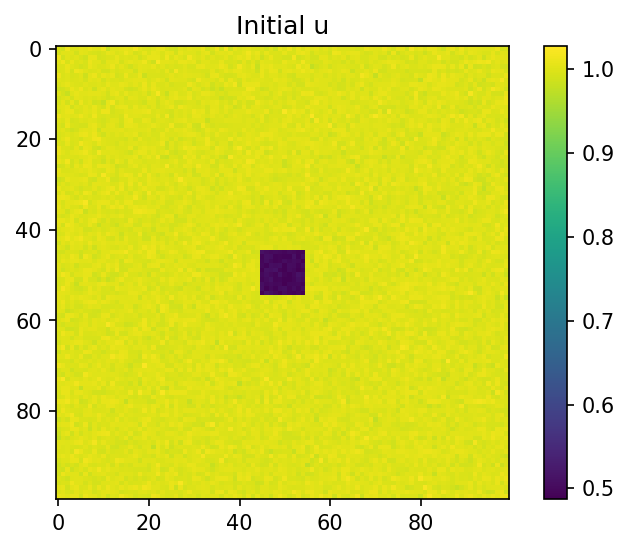

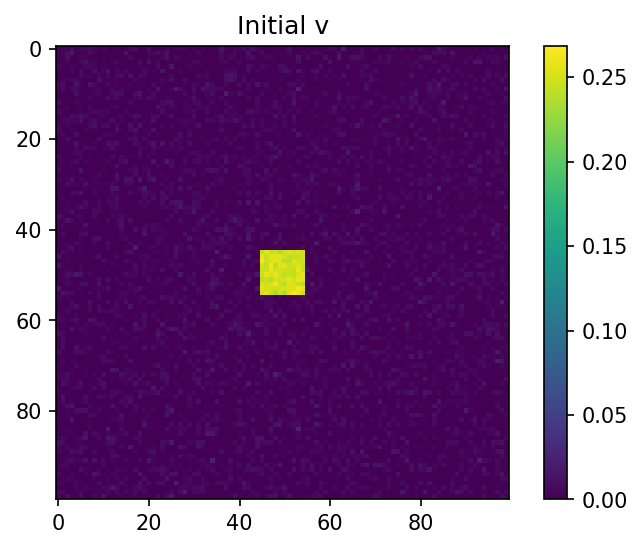

In [60]:
plt.imshow(u_matrix)
plt.colorbar()
plt.title('Initial u')
plt.show()
plt.imshow(v_matrix)
plt.colorbar()
plt.title('Initial v')
plt.show()

Bottom-left corner:
k = 0.0621
F = 0.03


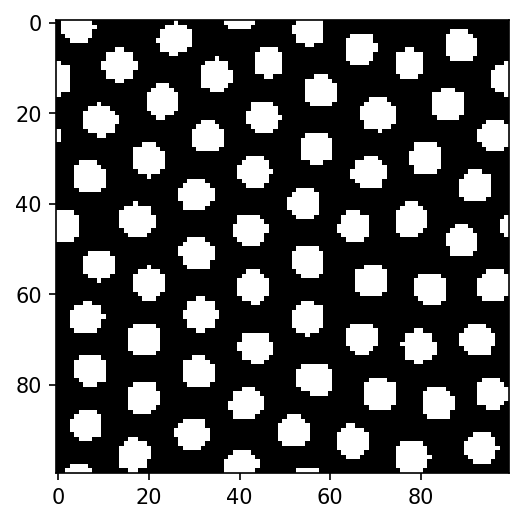

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in true_divide
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  


Bottom-right corner:
k = 0.0631
F = 0.03


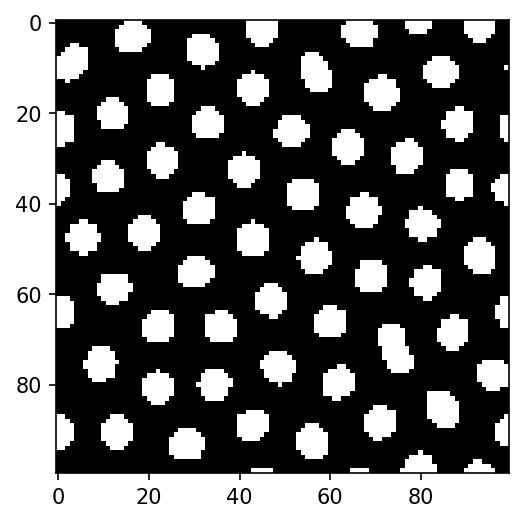



Middle:
k = 0.06265555555555556
F = 0.03666666666666667


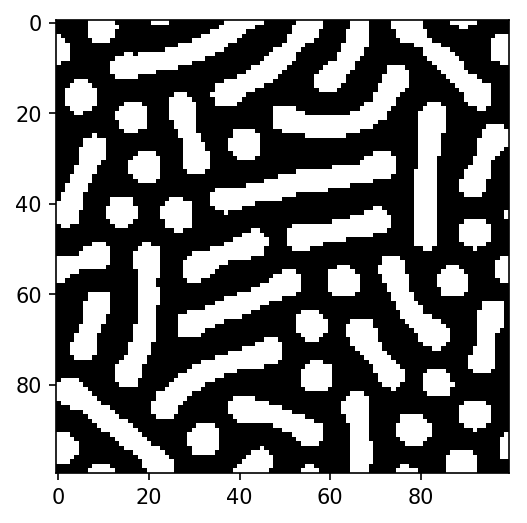



Top-left corner:
k = 0.0621
F = 0.042


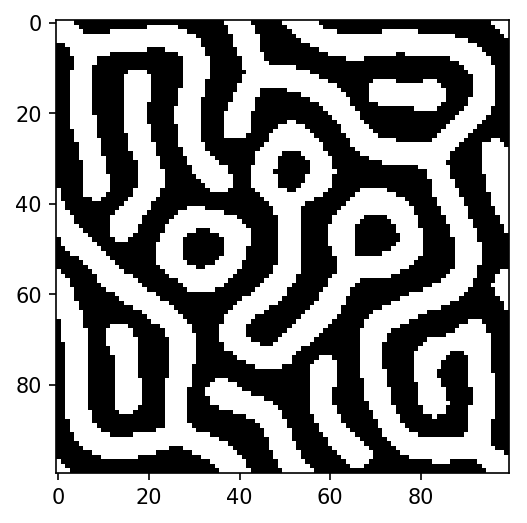



Top-right corner:
k = 0.0631
F = 0.042


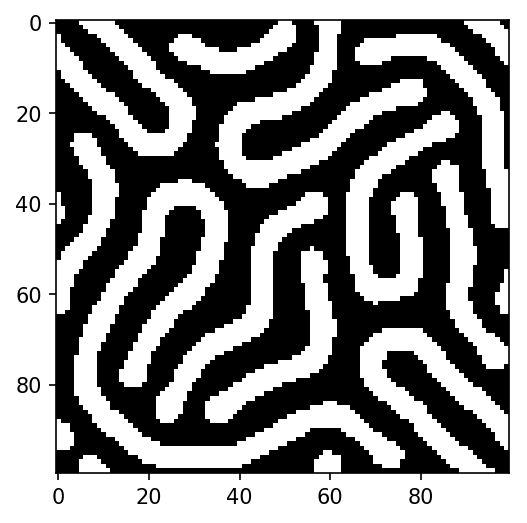

In [71]:
f_min = 0.03
f_max = 0.042
k_min = 0.0621
k_max = 0.0631
f_list = np.linspace(f_min,f_max,10)
k_list = np.linspace(k_min,k_max,10)

results = final_function(u_matrix,v_matrix,f_list,k_list,dx,dt,max_time,D_u,D_v,sink,GrayScott,normalizer,supplement
                   ,blob_detector,funct,shannon_entropy)

#print(results)


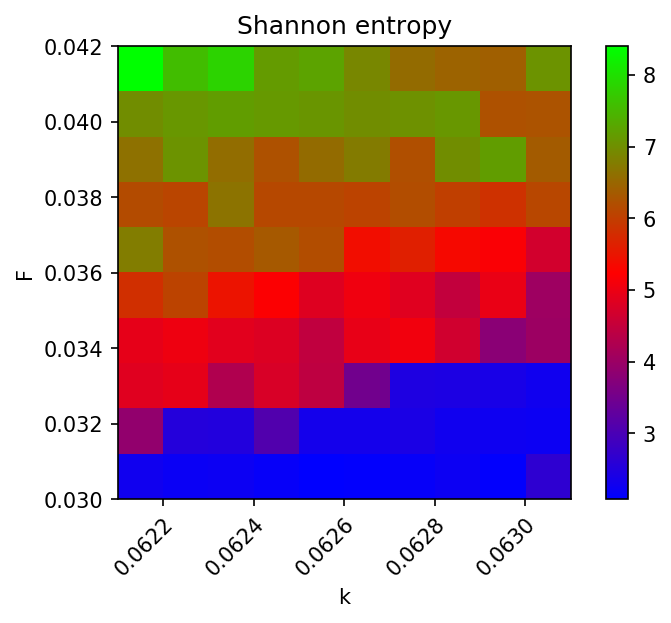

In [72]:
fig, ax = plt.subplots()
im = ax.imshow(np.flip(results,0), extent = (k_min,k_max,f_min,f_max),cmap = 'brg',aspect = np.abs((k_max-k_min))/(f_max-f_min))
ax.set_xlabel('k')
ax.set_ylabel('F')
ax.set_title('Shannon entropy')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
fig.colorbar(im)
plt.show()